# TM10007 Group 4 -- ECG Data
Lara de Bats (5022037), Josefien van den Berg (4663381), Merel Goossens (4856902), Amber Liqui Lung (4464168)

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's. The code is divided in different segments that are explained in our report.

In [1]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pylab as pl
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn import set_config

from imblearn.over_sampling import SMOTE

from IPython.display import display

pd.set_option('display.max_rows', 30)

## 1. Data loading, initial split, exploring and cleaning

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe. Then we are going to split the dataset into test data and training data.

In [2]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 409 (delta 39), reused 15 (delta 5), pack-reused 337
Receiving objects: 100% (409/409), 95.73 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (219/219), done.
The number of samples: 827
The number of columns: 9001


Underneath we explore our dataset

In [3]:
# How many patients have a normal or abnormal ECG?
count0= (df['label'] == 0).sum()
count1= (df['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')
# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal 

There are 681 patients with label 0
There are 146 patients with label 1


Now we will perform our initial split

In [4]:
# Split the whole data set in a training and test set
features = df.loc[:, df.columns !="label"].to_numpy()
labels = df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = 42) 

Lets explore x_train

In [5]:
# Look at the size
print(f"The training set has {x_train.shape[0]} samples and {x_train.shape[1]} features with {y_train.shape[0]} labels")
print(f"The test has {x_test.shape[0]} samples and {x_test.shape[1]} features with {y_test.shape[0]} labels")

# Look at the number of label 1 and label 0 in trainingset
count0= (y_train == 0).sum()
count1= (y_train == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')

# Look at the distribution
df = pd.DataFrame(x_train)
display(df.describe())

# Look at the type of data
print(x_train.dtype)

The training set has 661 samples and 9000 features with 661 labels
The test has 166 samples and 9000 features with 166 labels
There are 543 patients with label 0
There are 118 patients with label 1


,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
count,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,...,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000
mean,473.545787,68.219735,40.107831,30.223831,32.912681,42.555519,54.601058,38.398261,27.756282,22.688850,...,0.257628,0.256989,0.260101,0.261333,0.258008,0.259235,0.258205,0.251576,0.259956,0.258827
std,1090.597625,183.150669,82.932772,56.989313,58.226109,46.396159,61.963314,52.542619,41.189322,36.309774,...,0.466041,0.492337,0.453205,0.485969,0.523492,0.561868,0.473904,0.472443,0.533672,0.534501
min,0.031717,0.338026,0.374062,0.392388,0.442473,0.468230,0.291254,0.181994,0.168997,0.732216,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.048258,6.697330,7.502202,7.973962,9.699800,13.513050,17.151425,11.714197,8.290047,7.268737,...,0.083260,0.077778,0.085630,0.083037,0.077072,0.084123,0.084571,0.079911,0.074682,0.078336
50%,11.301568,14.319638,16.019461,15.585303,18.526251,26.475948,39.914146,24.261486,15.910253,13.764587,...,0.142454,0.140854,0.148017,0.139903,0.139145,0.132906,0.141514,0.137632,0.141386,0.132081
75%,414.437620,47.007877,36.407946,29.570521,34.987714,53.298597,77.536913,48.212765,30.232692,25.157698,...,0.254538,0.242179,0.261747,0.250637,0.241596,0.242516,0.260533,0.253220,0.249928,0.244466
max,9510.877805,2022.415412,963.283307,776.631173,1016.707977,443.762983,1051.557893,775.236262,483.852043,548.180243,...,6.808234,7.650954,8.154244,8.203337,8.772557,8.889082,9.048367,9.013666,9.058323,9.035147


float64


As a last step, we want do delelte entire rows and columns with only zeros or NaN as that can be seen as missing data.

In [6]:
#Delete rows and columns with only zero's or NaN's
def delete_missing_rows(x, y):
  concat = np.c_[x, y]

  for row in x:
    index = np.where((row == 0).all) or np.where((row == np.nan).all)
    np.delete(concat, index, 0)
  
  x =  concat[:,:-1]
  y = concat[:,-1] 
  return x, y

x_train, y_train = delete_missing_rows(x_train, y_train)

## 2. Data preprocessing - creating pipelines
Datasets with missing values that are filled with placeholders such as NaN and None, can cause problems when using estimators. Therefore you want to perform imputation in order to create usable datasets.

Underneath we create the functions for the imputation steps

In [7]:
# #Replace nan's and zeros since the chance of a zero is very low due to only float types
# def replace_missing_values(x): 
#   imp = SimpleImputer(missing_values = np.nan, strategy='mean', copy = False)
#   imp.fit_transform(x, y=None) #removes entire columns if it contains only missing values

#   imp = SimpleImputer(missing_values = 0, strategy='mean', copy = False)
#   imp.fit_transform(x, y=None) #removes entire columns if it contains only missing values
#   return x

# # Call functions to perform imputation steps and rename x_train
# x_train_imp = replace_missing_values(x_train)

# count0= (x_train_imp == 0).sum() 
# countNaN = np.isnan(x_train_imp)[np.isnan(x_train_imp) == True].size
# print(f"There are {count0} zeros and {countNaN} NaN values left in the dataset")

## 3. Data scaling, extraction and feature selection
In this section we will explore multiple scaling methods, determine if we will use PCA and define the treshold and we will explore mutliple feature selection methods. After this section we will have a dictionary containing the x_train data for all combinations of the chosen scaling, extraction (PCA) and selection methods.


There are multiple ways to scale features by standarization and normalization.

In [8]:
# # 1. Standardization of the data
# scaler_standard = StandardScaler()
# x_scaled_standard = scaler_standard.fit_transform(x_train_imp) 

# # # 2. Min-max scaling
# # scaler_minmax = MinMaxScaler()
# # x_scaled_minmax = scaler_minmax.fit_transform(x_train_imp)

# # 3. Robust scaling --> Robust is removed due to a to extensive loading time during the training of SVC
# scaler_robust= RobustScaler()
# x_scaled_robust = scaler_robust.fit_transform(x_train_imp)

# x_scaled = {"standard":x_scaled_standard, "robust":x_scaled_robust}

Now we are going to perform PCA and determine the treshold.

In [9]:
# # PCA
# plt.close('all') #before plotting, close all old windows
# x_scaled_pca = {} #create dictionary to add all combinations of scaling combined with PCA to

# for key, x in x_scaled.items():
    
#     # applying pca
#     pca_setting = PCA(n_components = 0.95) # threshold at 95% method
#     x_pca = pca_setting.fit_transform(x)
#     x_scaled_pca[f"x_{key}_PCA"] = x_pca

#     # plot to show treshold choice
#     pca_figure = PCA().fit(x)
#     plt.rcParams["figure.figsize"] = (12,6)

#     fig, ax = plt.subplots()
#     xi = np.arange(1, 662, step=1)
#     y = np.cumsum(pca_figure.explained_variance_ratio_)

#     plt.ylim(0.0,1.1)
#     plt.plot(xi, y, marker='o', linestyle='--', color='b')

#     plt.xlabel('Number of Components')
#     plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
#     plt.ylabel('Cumulative variance (%)')
#     plt.title(f'The number of components needed to explain variance for scaling method {key}')

#     plt.axhline(y=0.95, color='r', linestyle='-')
#     plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

#     plt.axhline(y=0.85, color='r', linestyle='-')
#     plt.text(0.5, 0.8, '85% cut-off threshold', color = 'red', fontsize=16)

#     plt.axhline(y=0.75, color='r', linestyle='-')
#     plt.text(0.5, 0.7, '75% cut-off threshold', color = 'red', fontsize=16)

#     ax.grid(axis='x')
#     plt.show()

Lasty we will look at feature selection. 

In [10]:
# # Feature selection with and without PCA
# x_scaled_selected = {} #create dictionary to add all combinations of scaling with or without PCA combined with feature selection

# selector = SelectKBest(f_classif)
# k = 10

# #Including PCA
# for key, x in x_scaled_pca.items():
#     selector.k = k
#     x_ffs = selector.fit_transform(x, y_train)  # ffs = f-test feature selection
#     x_scaled_selected[f"{key}_ffs"] =  x_ffs

# #Excluding PCA
# for key, x in x_scaled.items():
#     selector.k = k
#     x_ffs = selector.fit_transform(x, y_train)  # ffs = f-test feature selection
#     x_scaled_selected[f"x_{key}_ffs"] =  x_ffs

Now we finish with a dictionary x_scaled_selected that inclused all combinations between feature scaling, feature extraction (PCA) and feature selection.

## 4. Classifiers: hyperparameter tuning and fitting
In this section we will build a neural network and train our different clasiffiers (standard and the neural network) and compare their functionality in terms of F1 and average precision. We will perform this for all possible combinations of scaling, selection and classification possibilities. This is also the section were we will tune our parameters.

First we are going to set the pipelines and parameters we are going to tune and write the function for tuning. 

In [11]:
# Creating a dictionary of all proposed pipelines
k = 10
rs = None #Set random state, 42 only added in the last run
nc = 0.95 #Set n_components for PCA

models_all_combinations = {"standard_pca_ffs":{"KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()), ("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]),
          "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
          "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
          "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
          
          "robust_pca_ffs":{"KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]), 
          "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
          "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
          "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("pca", PCA()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
          
          "standard_ffs":{"KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]),
          "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
          "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
          "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])},
          
          "robust_ffs":{"KNeighborsClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", RobustScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', KNeighborsClassifier())]), 
          "RandomForestClassifier": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', RandomForestClassifier())]),
          "SVC": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c',SVC())]),
          "MLP": Pipeline([("impNaN", SimpleImputer()), ("imp0", SimpleImputer()),("scaler", StandardScaler()), ("selector", SelectKBest()), ('sampling', SMOTE()),('c', MLPClassifier())])}
          }

# Creating a dictionary of all parameters
model_parameters = {"KNeighborsClassifier":{"c__n_neighbors":[x for x in range(1, 300)], "c__weights": ["distance", "uniform"]},
                    "RandomForestClassifier":{"c__n_estimators":[x for x in range(2,100)], "c__max_depth":[x for x in range (1,100)], "c__min_samples_leaf": [x for x in range (50, 300)], "c__random_state" : [rs]},
                    "SVC":{"c__C": [x for x in np.arange(0.0001, 50, 0.0001)], "c__kernel": ["rbf", "poly"], "c__degree":[x for x in range (2,4)], "c__random_state" : [rs]},
                    "MLP": {"c__hidden_layer_sizes": [10,610,100], "c__activation": ["relu", "logistic", "tanh"], "c__solver": ["sgd", "adam", "lbgfs"], 
                            "c__learning_rate": ["constant", "adaptive"], "c__max_iter":[100], "c__random_state" : [rs]}
                    }  

param_with_PCA = {"imp0__missing_values": [0], "pca__n_components" : [nc], "pca__random_state": [rs], "selector__k": [k], "sampling__sampling_strategy": ["minority"], "sampling__random_state":[rs]}  
param_without_PCA = {"imp0__missing_values": [0], "selector__k": [k], "sampling__sampling_strategy": ["minority"], "sampling__random_state":[rs]}      



Now we are going to write the functions to execute the Randomized search, return the needed results for the validation plots and plot the loss curves for the MLP classifier

In [12]:
# Function to clean up results and create dataframe with wanted results
def get_dataframe_from_results(results, scorer):
  """ This function makes sure that we can clean up the results that we get from the grid search and leaves is with the necessary results"""
  df_to_concat = [pd.DataFrame(results["params"])]

  for key in scorer:
    df_to_concat.append(pd.DataFrame(results[f"mean_train_{key}"], columns=[f"mean_train_{key}"]))
    df_to_concat.append(pd.DataFrame(results[f"mean_test_{key}"], columns=[f"mean_test_{key}"]))
    df_to_concat.append(pd.DataFrame(results[f"std_train_{key}"], columns=[f"std_train_{key}"]))
    df_to_concat.append(pd.DataFrame(results[f"std_test_{key}"], columns=[f"std_test_{key}"]))

  return pd.concat(df_to_concat, axis=1)

# Function to do a grid search on each model using the parameters in the model_parameter dictionary
def parametertuning(CombinationName, Models, ModelParameters, n_splits, n_iter, random_state, scorer, refit, X, Y):
  """ This function performs the parameter tuning by doing a gridsearch with multiple parameters per model it returns the results that are cleaned up and only show the necessary"""
  results = {} #create a dictionary to save results

  for model_name, parameters in ModelParameters.items():
    print(f"Randomized searching {model_name}")
    model = Models[model_name]  # Find corresponding model in models dict

    # Add constant parameters to the 
    if 'pca' in CombinationName:
      params_complete = {**param_with_PCA, **parameters}
    else:
      params_complete = {**param_without_PCA, **parameters}

    # Create the Cross vallidation object for inner and outer cross validation
    cv_inner = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    cv_outer = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)   
    
    # Perform a grid search for the best parameters for the model using the test data and KFold
    randomized_search = RandomizedSearchCV(model, params_complete, cv=cv_inner, n_iter=n_iter, n_jobs=-1, verbose=False, scoring=scorer, refit=refit, return_train_score=True, random_state = random_state) 
    randomized_search.fit(X, Y)

    # Results of grid search
    best_estimator = randomized_search.best_estimator_ # Returns the model with the best parameters filled in based on refit scoring metric
    best_params = randomized_search.best_params_ 
    best_score = randomized_search.best_score_
    randomized_search_results = get_dataframe_from_results(randomized_search.cv_results_, scorer) # Extracts the necessary results 

    #Compute the outer cross validation scores to compare models (also the accuracy to see if we still are above the 85% in the assignment)
    a_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer)) 
    f1_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer, scoring = scorer["F1"])) 
    AUC_outer = np.mean(cross_val_score(best_estimator, X, Y, cv=cv_outer, scoring = scorer["AUC"])) 

    # if model_name is "MLP":
    #   plt.plot(Models[CombinationName]["MLP"].loss_curve_)
    #   plt.title(f"MLP loss curve for {CombinationName}")
    #   plt.xlabel('Epochs')
    #   plt.ylabel('Loss')

    # outer_scores = cross_validate(randomized_search, X, Y, cv=cv_outer, scoring = scorer, return_train_score = True, return_estimator = True) -- NOG VERWIJDEREN

    # Add the results to the dictionary
    results[model_name] = {"BestEstimator": best_estimator, "BestParams":best_params, "BestScore":best_score, "Accuracy_outer":a_outer, "F1_outer":f1_outer, "AUC_outer":AUC_outer, "GSresults": randomized_search_results}

  
  return results

Now we are going write the function to plot the validation curves to estimate if we are giving the randomized search the correct ranges.

In [13]:
# Functions to create validation plots

#---------------Plot for KNeighborsClassifier---------------
def plot_knn(results, scoring, combination_name, ModelParameters):
  knn_df = results["KNeighborsClassifier"]["GSresults"]
  uni_knn_df = knn_df[knn_df["c__weights"] == "uniform"]
  dist_knn_df = knn_df[knn_df["c__weights"] == "distance"]

  fig, ax = plt.subplots(2,2) #create subplot
  fig.suptitle(f"KNN validation plots for {combination_name}", fontsize=12)

  # For uniform weight
  grouped_n = uni_knn_df.groupby(by=["c__n_neighbors"]).mean()
  param_list = grouped_n.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,0].plot(param_list, grouped_n[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,0].plot(param_list, grouped_n[f"mean_test_{score}"], label=f"Test")  # plot the test F1 score
    ax[i,0].set_title(f"Uniform {score}")
    ax[i,0].set_xlabel(f"n_neighbors")
    ax[i,0].set_ylabel(f"{score}")
    ax[i,0].legend(loc='lower right')

  # For distance weight
  grouped_n = dist_knn_df.groupby(by=["c__n_neighbors"]).mean()
  param_list = grouped_n.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,1].plot(param_list, grouped_n[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,1].plot(param_list, grouped_n[f"mean_test_{score}"], label="Test")  # plot the test F1 score
    ax[i,1].set_title(f"Distance {score}")
    ax[i,1].set_xlabel(f"n_neighbors")
    ax[i,1].set_ylabel(f"{score}")
    ax[i,1].legend(loc='lower right')

  
  for ax in fig.get_axes():
    ax.label_outer()
  
#---------------Plot for SVC Classifier--------------- 
def plot_svc(results, scoring, combination_name, ModelParameters):
  svc_df = results["SVC"]["GSresults"]
  rbf_svc_df = svc_df[svc_df["c__kernel"]=="rbf"]
  poly_svc_df = svc_df[svc_df["c__kernel"]=="poly"]

  fig, ax = plt.subplots(2,3) #create subplot
  fig.suptitle(f"SVC validation plots for {combination_name}", fontsize=12)

  # For RBF kernel
  grouped_C = rbf_svc_df.groupby(by=["c__C"]).mean()
  param_list = grouped_C.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

  for score, i in zip(scoring, range(0,2)): 
    ax[i,0].plot(param_list, grouped_C[f"mean_train_{score}"], label="Train")  # plot the train F1 score
    ax[i,0].plot(param_list, grouped_C[f"mean_test_{score}"], label="Test")  # plot the test F1 score
    ax[i,0].set_title(f"RBF {score}")
    ax[i,0].set_xlabel(f"C")
    ax[i,0].set_ylabel(f"{score}")
    ax[i,0].legend(loc='lower right')
    
  #For Poly kernels 
  for degree, i in zip(range(2,4), range(1,3)):
    degree_svc_df = poly_svc_df[poly_svc_df["c__degree"]==degree]
    grouped_C = degree_svc_df.groupby(by=["c__C"]).mean()
    param_list = grouped_C.index.to_numpy()  # Pakt de parameters die op de x as gezet worden

    for score, j in zip(scoring, range(0,2)): 
      ax[j,i].plot(param_list, grouped_C[f"mean_train_{score}"], label="Train")  # plot the train F1 score
      ax[j,i].plot(param_list, grouped_C[f"mean_test_{score}"], label="Test")  # plot the test F1 score
      ax[j,i].set_title(f"Poly degree {degree} {score}")
      ax[j,i].set_xlabel(f"C")
      ax[j,i].set_ylabel(f"{score}")
      ax[j,i].legend(loc='lower right')

  for ax in fig.get_axes():
    ax.label_outer()
       
# ---------------Plot for RandomForestClassifier---------------
def plot_randomforest(results, scoring, combination_name, ModelParameters):
    forest_df = results["RandomForestClassifier"]["GSresults"]

    fig, ax = plt.subplots(2,3) #create subplot
    fig.suptitle(f"Decision tree validation plots for {combination_name}", fontsize=12)
    
    for param, j in zip(ModelParameters["RandomForestClassifier"], range(0,3)):
      grouped = forest_df.groupby(by=[param]).mean()
      param_list = grouped.index.to_numpy()  # Pakt de parameters die op de x as gezet worden
      
      for score, i in zip(scoring, range(0,2)): 
        ax[i,j].plot(param_list, grouped[f"mean_train_{score}"], label="Train")  # plot the train F1 score
        ax[i,j].plot(param_list, grouped[f"mean_test_{score}"], label="Test")  # plot the test F1 score
        ax[i,j].set_title(f"{param.replace('c__', '')}")
        ax[i,j].set_xlabel(f"{param.replace('c__', '')}")
        ax[i,j].set_ylabel(f"{score}")
        ax[i,j].legend(loc='lower right')
    
    for ax in fig.get_axes():
      ax.label_outer()

Beneath, we write the function to display the best scoring results for each model.

In [14]:
# Plot tabel with scoring metric and optimal paramater combination per scalor and selection
def create_table_of_results(results_all_combinations, combination_name):
  model_names = [] 
  best_params = []
  best_scores = []

  # F1_scores = []
  # AUC_scores = []
  Mean_Accuracy = []
  Mean_F1 = []
  Mean_AUC = []

  results = results_all_combinations[combination_name]

  for model_name in results:

    # Create column with model names
    model_names.append(model_name)

    # Create column with best params
    best_param = results[model_name]["BestParams"]
    best_params.append(best_param)

    # Create column with best inner score
    best_score = results[model_name]["BestScore"]
    best_scores.append(best_score)

    # # Create column with F1 scores of inner cross validation
    # F1 = results[model_name]["GSresults"]["mean_test_F1"].max()
    # F1_scores.append(F1)

    # # Create column with Average precision scores of inner cross validation
    # AUC = results[model_name]["GSresults"]["mean_test_AUC"].max()
    # AUC_scores.append(AUC)
    
    # Create column with accuracy scores of outer cross validation of best estimator
    mean_accuracy = results[model_name]["Accuracy_outer"]
    Mean_Accuracy.append(mean_accuracy)

    # Create column with accuracy scores of outer cross validation of best estimator
    mean_f1 = results[model_name]["F1_outer"]
    Mean_F1.append(mean_f1)
    
    # Create column with accuracy scores of outer cross validation of best estimator
    mean_AUC = results[model_name]["AUC_outer"]
    Mean_AUC.append(mean_AUC)

  print(f"Table of results for combination {combination_name}")
  display(pd.DataFrame({"ModelName":model_names, "BestParams":best_params, "Best inner F1 score": best_scores, "Outer accuracy of BE":Mean_Accuracy, "Outer F1 of BE":Mean_F1, "Outer AUC of BE":Mean_AUC}).style.hide(axis='index'))
  print()

Lastly, we will call all functions written to tune all the parameters and plot the results for each combination of scaling, PCA and selection.

In [15]:
# Perform training
results_all_combinations = {}

for combination_name, models in models_all_combinations.items():

  #Create scorers
  f1_scorer = make_scorer(f1_score, labels = None, average = 'binary', pos_label = 1) 
  scoring = {"F1":f1_scorer, "AUC":"roc_auc"} #Determine what type of scoring you want to use
  
  #Ignorme warnings from MLP
  import warnings
  warnings.filterwarnings('ignore') 

  # Perform randomized search
  results = parametertuning(combination_name, models, model_parameters, 5, 50, None, scoring, "F1", x_train, y_train)
  results_all_combinations[combination_name] = results

Randomized searching KNeighborsClassifier
Randomized searching RandomForestClassifier
Randomized searching SVC
Randomized searching MLP
Randomized searching KNeighborsClassifier
Randomized searching RandomForestClassifier
Randomized searching SVC
Randomized searching MLP
Randomized searching KNeighborsClassifier
Randomized searching RandomForestClassifier
Randomized searching SVC
Randomized searching MLP
Randomized searching KNeighborsClassifier
Randomized searching RandomForestClassifier
Randomized searching SVC
Randomized searching MLP


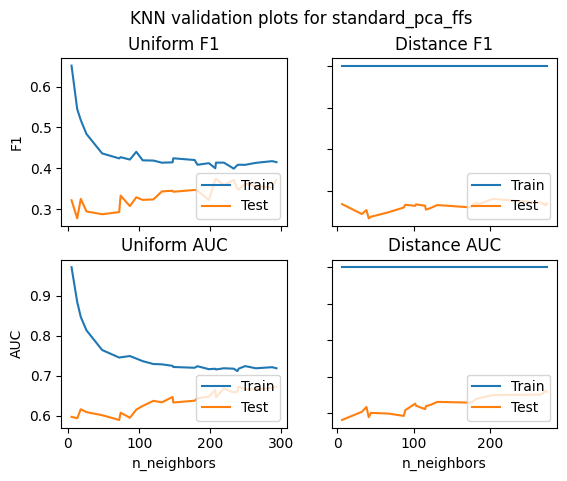

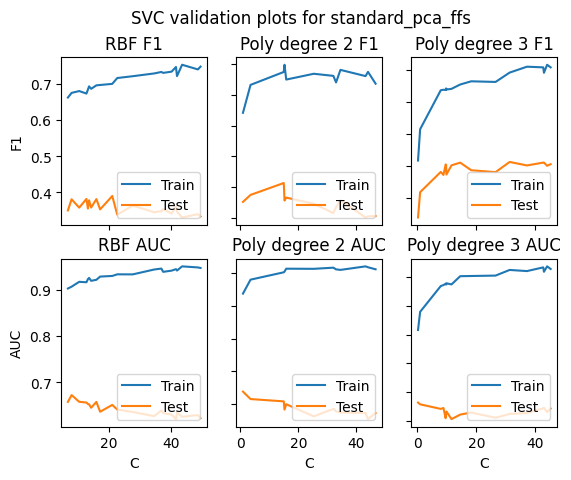

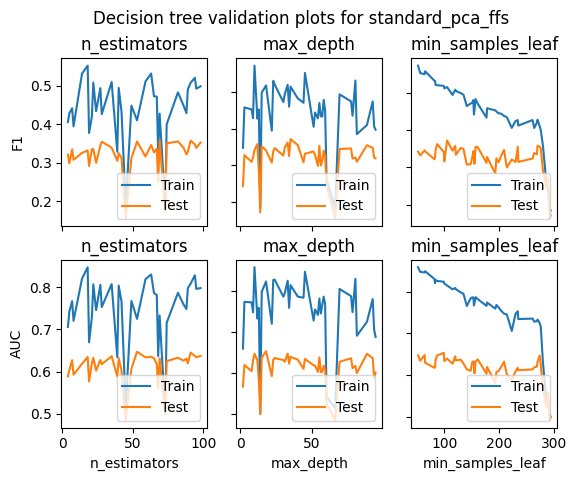

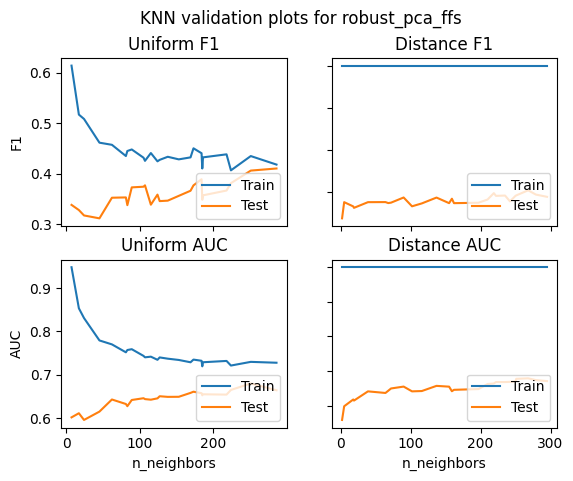

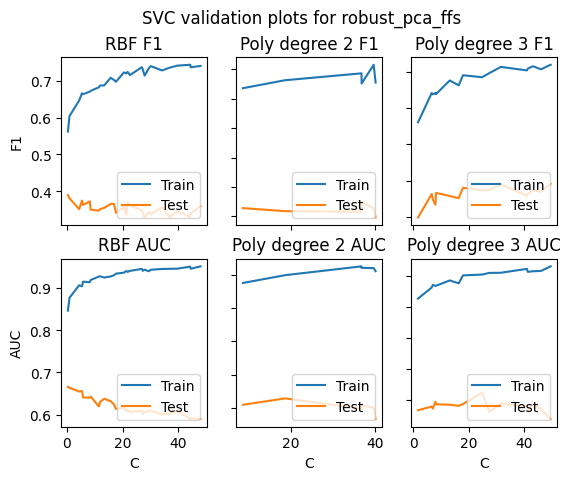

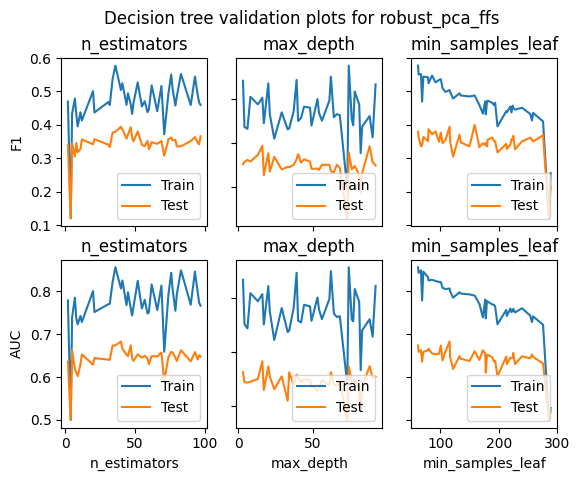

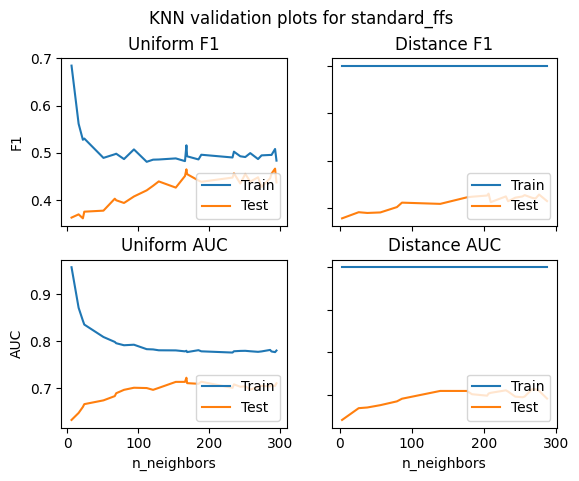

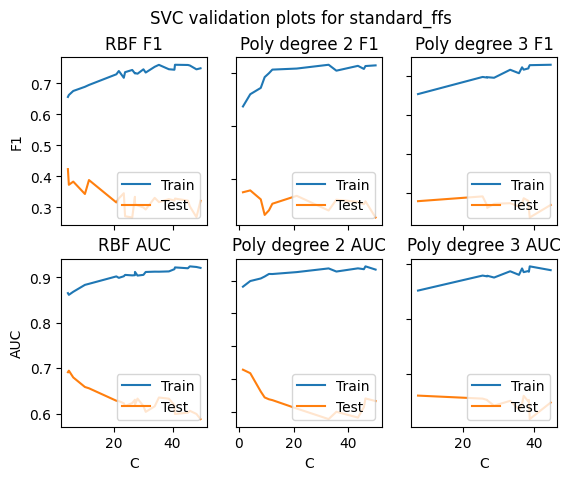

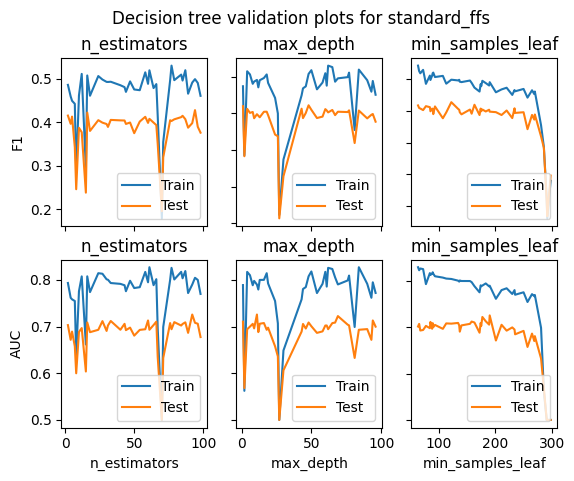

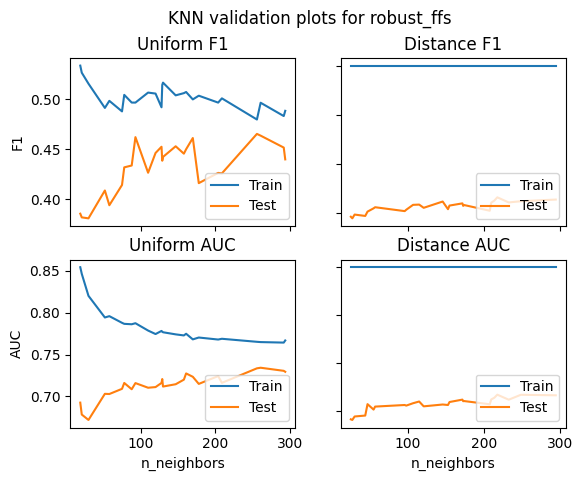

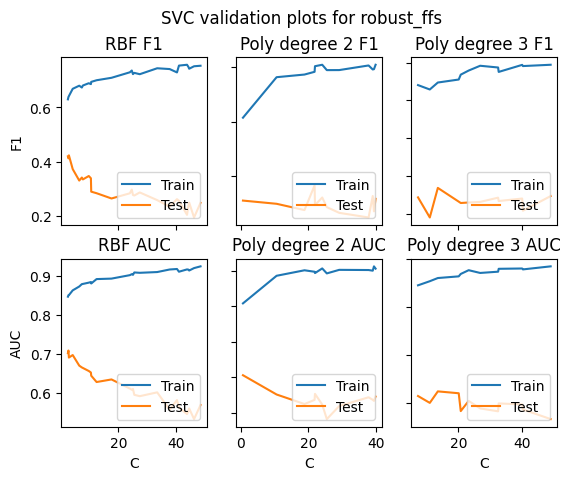

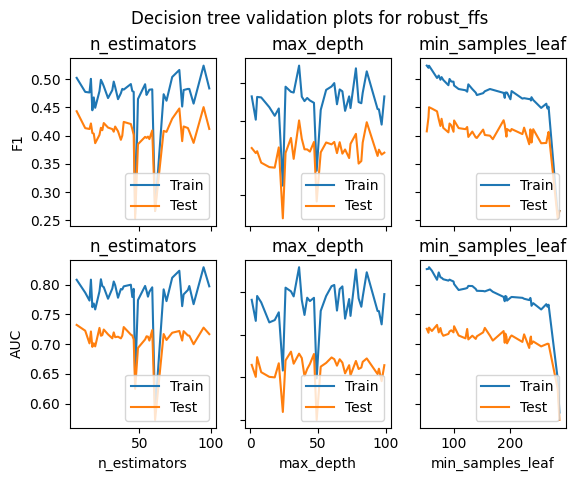

In [16]:
# Create visualization of results 
plt.close('all') #make sure you class all windows before plotting to prevent plotting in the same figure

for combination_name in models_all_combinations:

  #Create all validation plots to show the relation between the scoring type and parameters for every combination
  plot_knn(results_all_combinations[combination_name], scoring, combination_name, model_parameters)
  plot_svc(results_all_combinations[combination_name], scoring, combination_name, model_parameters)
  plot_randomforest(results_all_combinations[combination_name], scoring, combination_name, model_parameters)

In [17]:
# Create table with results for every combination
for combination_name in models_all_combinations:
  create_table_of_results(results_all_combinations, combination_name)

Table of results for combination standard_pca_ffs


ModelName,BestParams,Best inner F1 score,Outer accuracy of BE,Outer F1 of BE,Outer AUC of BE
KNeighborsClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__weights': 'uniform', 'c__n_neighbors': 208}",0.374368,0.724527,0.368127,0.654197
RandomForestClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__random_state': None, 'c__n_estimators': 63, 'c__min_samples_leaf': 105, 'c__max_depth': 35}",0.371948,0.703520,0.383547,0.692305
SVC,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__random_state': None, 'c__kernel': 'poly', 'c__degree': 3, 'c__C': 31.305100000000003}",0.411816,0.807906,0.387411,0.636807
MLP,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__solver': 'adam', 'c__random_state': None, 'c__max_iter': 100, 'c__learning_rate': 'adaptive', 'c__hidden_layer_sizes': 100, 'c__activation': 'tanh'}",0.436349,0.727649,0.411970,0.693192



Table of results for combination robust_pca_ffs


ModelName,BestParams,Best inner F1 score,Outer accuracy of BE,Outer F1 of BE,Outer AUC of BE
KNeighborsClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__weights': 'uniform', 'c__n_neighbors': 286}",0.410196,0.700376,0.335126,0.656643
RandomForestClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__random_state': None, 'c__n_estimators': 71, 'c__min_samples_leaf': 159, 'c__max_depth': 13}",0.399988,0.717088,0.404320,0.692320
SVC,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__random_state': None, 'c__kernel': 'poly', 'c__degree': 3, 'c__C': 49.54370000000001}",0.391849,0.800262,0.359258,0.652549
MLP,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'pca__random_state': None, 'pca__n_components': 0.95, 'imp0__missing_values': 0, 'c__solver': 'sgd', 'c__random_state': None, 'c__max_iter': 100, 'c__learning_rate': 'constant', 'c__hidden_layer_sizes': 10, 'c__activation': 'relu'}",0.404156,0.697562,0.418276,0.726420



Table of results for combination standard_ffs


ModelName,BestParams,Best inner F1 score,Outer accuracy of BE,Outer F1 of BE,Outer AUC of BE
KNeighborsClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__weights': 'uniform', 'c__n_neighbors': 293}",0.466632,0.800319,0.396426,0.726723
RandomForestClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__random_state': None, 'c__n_estimators': 94, 'c__min_samples_leaf': 122, 'c__max_depth': 26}",0.427957,0.711005,0.404048,0.761071
SVC,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__random_state': None, 'c__kernel': 'rbf', 'c__degree': 3, 'c__C': 4.1685}",0.423117,0.773103,0.410521,0.661749
MLP,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__solver': 'sgd', 'c__random_state': None, 'c__max_iter': 100, 'c__learning_rate': 'constant', 'c__hidden_layer_sizes': 100, 'c__activation': 'relu'}",0.466399,0.744418,0.433422,0.746306



Table of results for combination robust_ffs


ModelName,BestParams,Best inner F1 score,Outer accuracy of BE,Outer F1 of BE,Outer AUC of BE
KNeighborsClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__weights': 'uniform', 'c__n_neighbors': 256}",0.465158,0.788300,0.429980,0.753709
RandomForestClassifier,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__random_state': None, 'c__n_estimators': 95, 'c__min_samples_leaf': 57, 'c__max_depth': 36}",0.450447,0.733664,0.428556,0.723816
SVC,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__random_state': None, 'c__kernel': 'rbf', 'c__degree': 2, 'c__C': 2.8934}",0.423818,0.755081,0.454362,0.678907
MLP,"{'selector__k': 10, 'sampling__sampling_strategy': 'minority', 'sampling__random_state': None, 'imp0__missing_values': 0, 'c__solver': 'sgd', 'c__random_state': None, 'c__max_iter': 100, 'c__learning_rate': 'adaptive', 'c__hidden_layer_sizes': 100, 'c__activation': 'logistic'}",0.468721,0.744327,0.482020,0.733469


## 5. The final model
After the previous steps we determined the best combination of scaling, PCA, feature selection and classification for our final model. Underneath we wrote the final pipeline that returns the mean accuracy of the model on the test data.

In [18]:
# Write final pipeline with chosen combinations
def final_pipeline(x_train, y_train, results_all_combinations):
    """This function goes trough all the steps of the final model setup chosen in the previous section. Note: you need to run sections loading packages, 1, 2 and 4 in order to run this code"""
    
    # Determine steps of the pipeline
    pipe = results_all_combinations["robust_ffs"]["SVC"]["BestEstimator"]
    print(f"The steps of the final model look are {pipe}\n")

    pipe_params = pipe.get_params()
    print(pipe_params)


    # Fit the pipeline on the training data 
    pipe.fit(x_train, y_train)

    # Compute the mean accuracy of the model on the test data
    y_pred= pipe.predict(x_test)
    score_f1 = f1_score(y_test, y_pred)
    score_AUC = roc_auc_score(y_test, y_pred)
    score_accuracy = accuracy_score(y_test, y_pred)

    return score_f1, score_AUC, score_accuracy

#Execute pipeline to get the mean accuracy of the final model on the test data
score_f1, score_AUC, score_accuracy = final_pipeline(x_train, y_train, results_all_combinations)
print(f"The scores of the final model are: f1 = {score_f1}, AUC = {score_AUC} and accuracy = {score_accuracy}")


The steps of the final model look are Pipeline(steps=[('impNaN', SimpleImputer()),
                ('imp0', SimpleImputer(missing_values=0)),
                ('scaler', StandardScaler()), ('selector', SelectKBest()),
                ('sampling', SMOTE(sampling_strategy='minority')),
                ('c', SVC(C=2.8934, degree=2))])

{'memory': None, 'steps': [('impNaN', SimpleImputer()), ('imp0', SimpleImputer(missing_values=0)), ('scaler', StandardScaler()), ('selector', SelectKBest()), ('sampling', SMOTE(sampling_strategy='minority')), ('c', SVC(C=2.8934, degree=2))], 'verbose': False, 'impNaN': SimpleImputer(), 'imp0': SimpleImputer(missing_values=0), 'scaler': StandardScaler(), 'selector': SelectKBest(), 'sampling': SMOTE(sampling_strategy='minority'), 'c': SVC(C=2.8934, degree=2), 'impNaN__add_indicator': False, 'impNaN__copy': True, 'impNaN__fill_value': None, 'impNaN__keep_empty_features': False, 'impNaN__missing_values': nan, 'impNaN__strategy': 'mean', 'impNaN__verbose': 'depre